https://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/

In [1]:
import urllib.request
import collections
import math
import os
import random
import zipfile
import datetime as dt

import numpy as np
import tensorflow as tf

In [10]:
# Read the data into a list of strings.
# def read_data(filename):
#     """Extract the first file enclosed in a zip file as a list of words."""
#     with zipfile.ZipFile(filename) as f:
#         data = tf.compat.as_str(f.read(f.namelist()[0])).split()
#     return data

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

#cz: all the last three variables below are under the size of vocabulary size
#data, list with "frequecy rank" in the text order
#count, ["one",'one','two'].most_common(2) is [('one', 2), ('two', 1)] i.e. tuple with "word" and "frequency"
#dictionary,  dicyionary with "word" and "frequency rank"
#reverse_dictionary, dictionary with "frequency rank" and "word"

In [8]:
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser
words=[]
with open("all_clean_words.txt") as mytxt:
    for line in mytxt:
        newline = line.split(" ")
        words.append(newline)
words=words[0]

sentences = Text8Corpus(datapath('/Users/CrystalZhang/Desktop/Global AI/UN materials/taxonomy/all_clean_words.txt'))
phrases = Phrases(sentences, min_count=5, threshold=50)

gram_words=phrases[words]

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['anarchism',
 'originate',
 'a',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'use',
 'against',
 'early',
 'work',
 'class',
 'radical',
 'include',
 'the',
 'digger',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans_culotte',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'be',
 'still',
 'use',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'use',
 'violent',
 'mean',
 'to',
 'destroy',
 'the',
 'organization',
 'of',
 'society',
 'it',
 'have',
 'also',
 'be',
 'take',
 'up',
 'a',
 'a',
 'positive',
 'label',
 'by',
 'self',
 'define',
 'anarchist',
 'the',
 'word',
 'anarchism',
 'be',
 'derive',
 'from',
 'the',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'a',
 'a',
 'political',
 'philosophy',
 'be',
 'the',
 'belief',
 'that',
 'ruler',
 'be',
 'unnecessary',
 'and',
 'should',
 'be',
 'abolish',
 'although',
 'there',
 'be',
 'differ',
 'interpretation',
 'of',
 'what',


In [12]:
data_index = 0
# generate batch data
def generate_batch(data, batch_size, num_skips, skip_window):
    global data_index#cz: global variable can be accessed inside or outside of the function
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window input_word skip_window ]
    buffer = collections.deque(maxlen=span)
    #cz: deque - Once a bounded length deque is full, when new items are added, 
    #a corresponding number of items are discarded from the opposite end. 
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        # If it gets to the end of the text stream,
        # the “% len(data)” component of the index update will basically reset the count back to zero.
    for i in range(batch_size // num_skips):
        target = skip_window  # input word at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)#Then other words are randomly selected from the span of words,
        #making sure that the input word is not selected as part of the context, and each context word is unique.
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]  # this is the input word
            context[i * num_skips + j, 0] = buffer[target]  # these are the context words
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, context

In [14]:
vocabulary_size = 10000
data, count, dictionary, reverse_dictionary = build_dataset(gram_words,vocabulary_size)

batch_size = 128
embedding_size = 300  # Dimension of the embedding vector.
skip_window = 2       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = vocabulary_size//20#16     # Random set of words to evaluate similarity on.
valid_window = vocabulary_size#100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

#cz: The code above randomly chooses 16 integers from 0-100 – this corresponds to the integer indexes 
#of the most common 100 words in our text data.  These will be the words we examine to assess how our 
#learning is progressing in associating related words together in the vector-space.  

In [15]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_context = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

#     # Construct the variables for the softmax
#     weights = tf.Variable(tf.truncated_normal([embedding_size, vocabulary_size],stddev=1.0 / math.sqrt(embedding_size)))
#     biases = tf.Variable(tf.zeros([vocabulary_size]))
#     hidden_out = tf.transpose(tf.matmul(tf.transpose(weights), tf.transpose(embed))) + biases

#     # convert train_context to a one-hot format
#     train_one_hot = tf.one_hot(train_context, vocabulary_size)
#     cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hidden_out, labels=train_one_hot))

#     # Construct the SGD optimizer using a learning rate of 1.0.
#     optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(cross_entropy)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_context,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    #cz: calculate the L2 norm of each vector using the tf.square(), tf.reduce_sum() and tf.sqrt() functions 
    #to calculate the square, summation and square root of the norm, respectively:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

In [28]:
# Step 5: Begin training.
num_steps = 40001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_context = generate_batch(
            data, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_context: batch_context}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
#         if step % 10000 == 0:
#             sim = similarity.eval()
#             for i in range(valid_size):
#                 valid_word = reverse_dictionary[valid_examples[i]]
#                 top_k = 8  # number of nearest neighbors
#                 nearest = (-sim[i, :]).argsort()[1:top_k + 1]
#                 log_str = 'Nearest to %s:' % valid_word
#                 for k in range(top_k):
#                     close_word = reverse_dictionary[nearest[k]]
#                     log_str = '%s %s,' % (log_str, close_word)
#                 print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  228.285400390625
Average loss at step  2000 :  40.59775573849678
Average loss at step  4000 :  8.572538392066956
Average loss at step  6000 :  6.258366871714592
Average loss at step  8000 :  5.551095504999161
Average loss at step  10000 :  5.293661845088005
Average loss at step  12000 :  5.146812681436539
Average loss at step  14000 :  5.002025862932205
Average loss at step  16000 :  4.9457320096492765
Average loss at step  18000 :  4.909323033571243
Average loss at step  20000 :  4.824682644486427
Average loss at step  22000 :  4.91328146314621
Average loss at step  24000 :  4.821514240860939
Average loss at step  26000 :  4.800096184849739
Average loss at step  28000 :  4.796076263487339
Average loss at step  30000 :  4.806341995000839
Average loss at step  32000 :  4.850256815075874
Average loss at step  34000 :  4.8021964758634565
Average loss at step  36000 :  4.826353049993515
Average loss at step  38000 :  4.690864866256714
Average loss at 

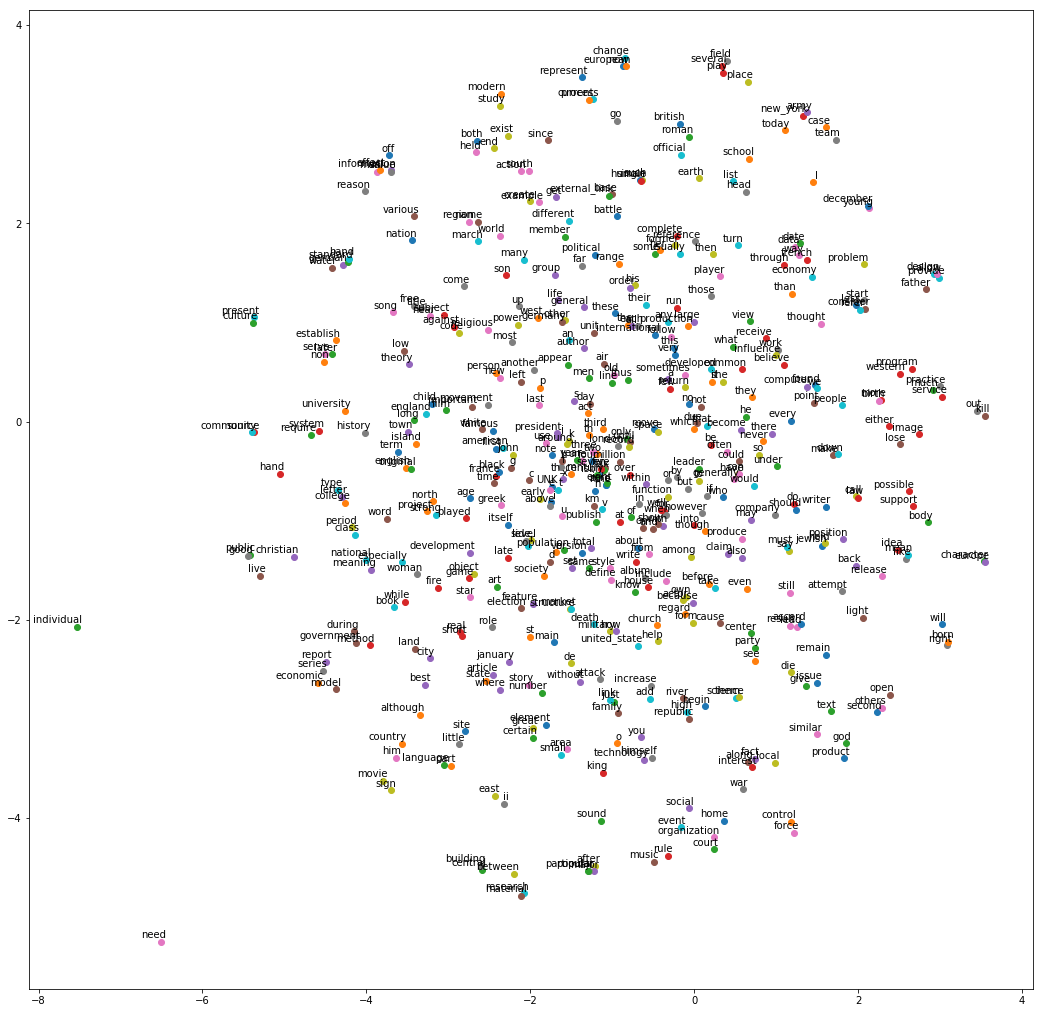

In [29]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')


In [38]:
#cz: show the result
file2 = open("/Users/CrystalZhang/Desktop/Global AI/UN materials/taxonomy/embedding.txt","w")
file2.write('{} {}'.format(vocabulary_size,embedding_size))
for i in range(vocabulary_size):
    #if (type(reverse_dictionary[i]) == np.str_):#remove integer!
    embed = final_embeddings[i, :]
    word = reverse_dictionary[i]
    file2.write('\n{} {}'.format(word,' '.join(map(str, embed))))
file2.close()

In [34]:
# import gensim
# from gensim.models import Word2Vec
# from gensim.test.utils import datapath, get_tmpfile
# from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec

# glove txt format to word2vec txt format
# https://radimrehurek.com/gensim/scripts/glove2word2vec.html 

# (1)from gensim.scripts.glove2word2vec import glove2word2vec
# glove2word2vec(glove_input_file="vectors.txt", word2vec_output_file="gensim_glove_vectors.txt")
# from gensim.models.keyedvectors import KeyedVectors
# glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

# (2)glove_file = datapath("/Users/CrystalZhang/Desktop/Global AI/UN materials/taxonomy/embedding.txt")
# tmp_file = get_tmpfile("test_word2vec.txt")
# _ = glove2word2vec(glove_file, tmp_file)
# model = KeyedVectors.load_word2vec_format(tmp_file)

from gensim.models.keyedvectors import KeyedVectors
embed_file = datapath("/Users/CrystalZhang/Desktop/Global AI/UN materials/taxonomy/embedding.txt")
model = KeyedVectors.load_word2vec_format(embed_file, binary=False)

In [39]:
model.most_similar('face')

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dye', 0.2632455825805664),
 ('monitor', 0.25229138135910034),
 ('pile', 0.24400904774665833),
 ('dickens', 0.2413543164730072),
 ('mexico', 0.24096673727035522),
 ('cede', 0.24026180803775787),
 ('middle', 0.2396976798772812),
 ('one', 0.23811465501785278),
 ('bankruptcy', 0.23409786820411682),
 ('philippe', 0.23283281922340393)]